In [ ]:
!nvidia-smi

Fri May  2 06:37:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Setup & Install Ultralytics

In [ ]:
!pip install ultralytics roboflow --upgrade -q

import ultralytics
ultralytics.checks()

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.4/112.6 GB disk)


# Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

project_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision Workshop/License Plate Detection"
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)

In [ ]:
!pwd

# Load Dataset from Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="your-api-key") # Roboflow API key
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(11)
dataset = version.download("yolov11")

In [ ]:
!ls

 License-Plate-Recognition-11	   runs         yolo11m.pt   yolo11s.pt
'LPR Detection Finetune YOLOv11'   yolo11l.pt   yolo11n.pt


In [ ]:
dataset.location

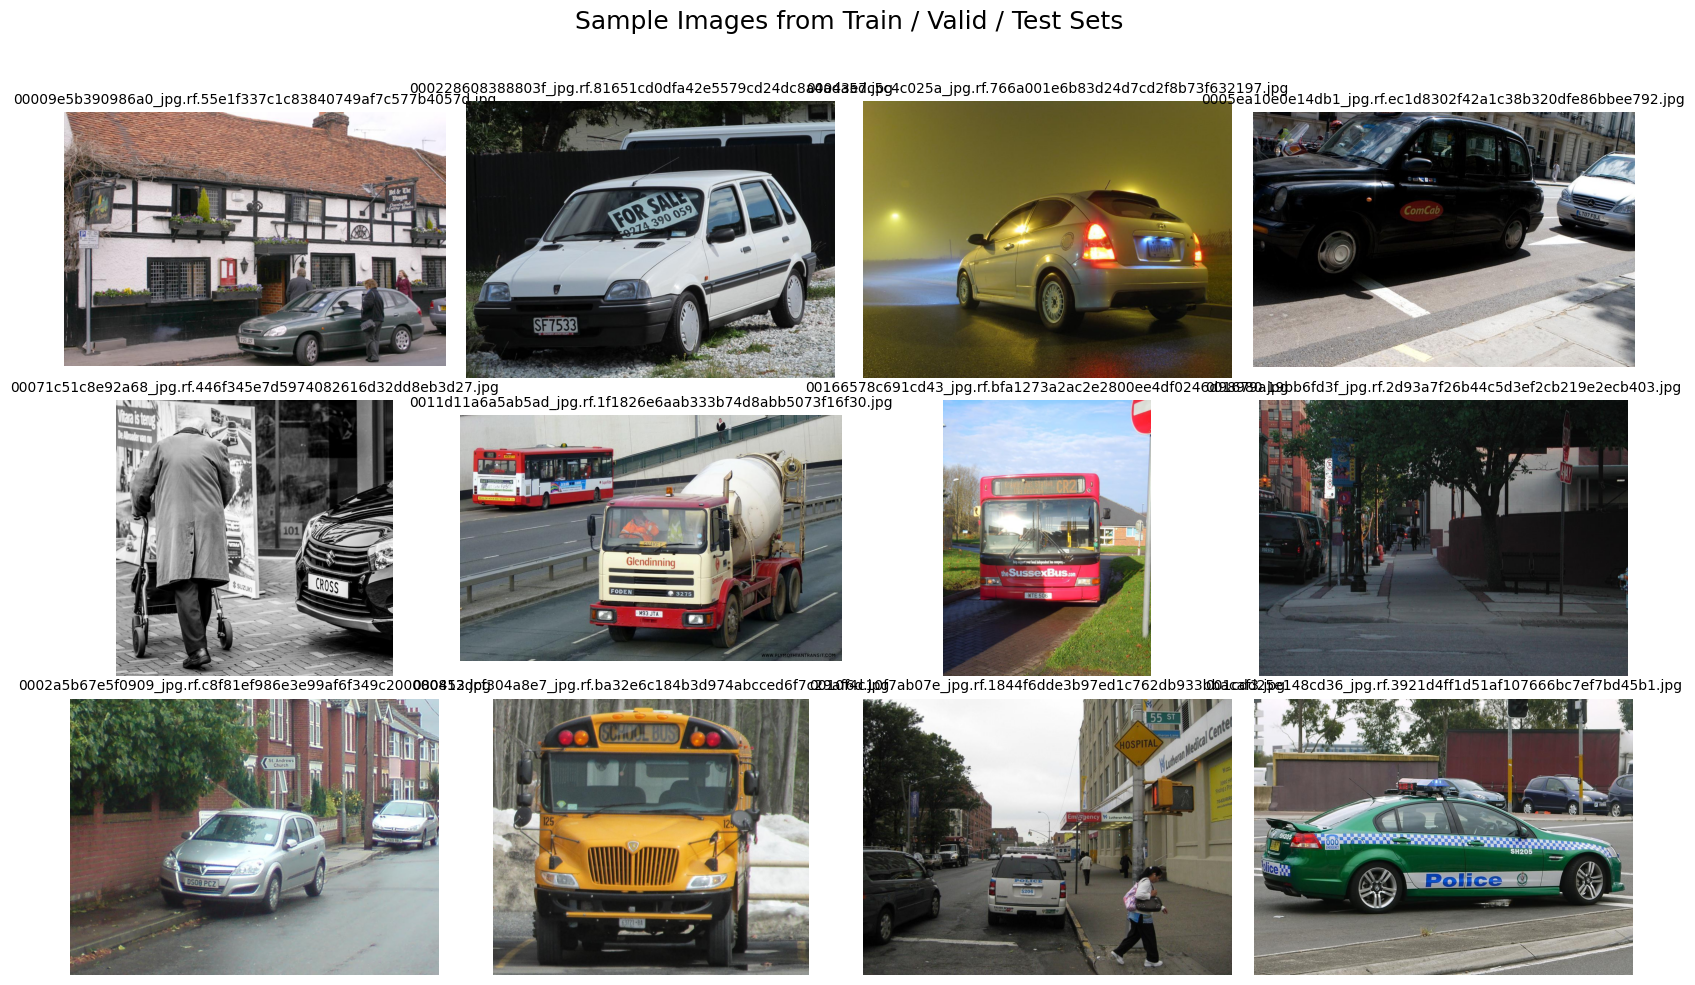

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Base directory from Roboflow dataset or your own custom structure
# base_path = dataset.location  # or "/content/drive/..." if use Google Drive
base_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision Workshop/License Plate Detection/License-Plate-Recognition-11"

# Your folder names: train / valid / test
sets = ['train', 'valid', 'test']
image_paths = []

# Collect 4 images from each subset
for split in sets:
    img_dir = os.path.join(base_path, split, 'images')
    if os.path.exists(img_dir):
        all_images = sorted(os.listdir(img_dir))
        sample_images = all_images[:4]  # Get first 4 images
        image_paths.extend([os.path.join(img_dir, img) for img in sample_images])
    else:
        print(f"Folder not found: {img_dir}")

# Plot images in 3 rows and 4 columns
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle('Sample Images from Train / Valid / Test Sets', fontsize=18)

for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    row = i // 4
    col = i % 4
    axs[row, col].imshow(img)
    axs[row, col].set_title(os.path.basename(img_path), fontsize=10)
    axs[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Fine Tuning using YOLOv11

---



## Resume Tuning

In [ ]:
from ultralytics import YOLO

# load lasted weight (last.pt) from /runs/{task}/...
model = YOLO(f"{project_dir}/runs/detect/license-plate-finetune-v1n/weights/last.pt")

# resume training..
model.train(
    resume=True
)


## Fine Tuning Model

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

model.train(
    data=f"{base_path}/data.yaml",
    epochs=300,
    imgsz=640,
    batch=16,
    name="license-plate-finetune-v1n",
    device=0, # GPU
    patience=15, # early stopping if not improve
    workers=2,
    val=True
)

100%|██████████| 109M/109M [00:00<00:00, 227MB/s]


Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/drive/MyDrive/Colab Notebooks/Computer Vision Workshop/LPR Detection/License-Plate-Recognition-11/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=None, name=lpr-finetune-v1x, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              


  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  8                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  9                  -1  1   1476864  ultralytics.nn.modules.block.SPPF            [768, 768, 5]                 
 10                  -1  2   3264768  ultralytics.nn.modules.block.C2PSA           [768, 768, 2]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   5612544  ultralytics.nn.modules.block.C3k2            [1536, 768, 2, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

train: Scanning /content/drive/MyDrive/Colab Notebooks/Computer Vision Workshop/LPR Detection/License-Plate-Recognition-11/train/labels.cache... 7057 images, 5 backgrounds, 0 corrupt: 100%|██████████| 7057/7057 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.1±0.1 MB/s, size: 20.8 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/Computer Vision Workshop/LPR Detection/License-Plate-Recognition-11/valid/labels.cache... 2048 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2048/2048 [00:00<?, ?it/s]


Plotting labels to runs/detect/lpr-finetune-v1x/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/lpr-finetune-v1x
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      14.9G      1.206      0.971      1.175          1        640: 100%|██████████| 442/442 [33:55<00:00,  4.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:17<00:00,  3.68it/s]

                   all       2048       2195      0.975      0.911      0.953      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      19.5G      1.218     0.6839      1.157          4        640: 100%|██████████| 442/442 [01:51<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]


                   all       2048       2195      0.931      0.874      0.916      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      19.5G      1.288     0.8028      1.201          1        640: 100%|██████████| 442/442 [01:52<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]

                   all       2048       2195      0.883      0.807      0.862      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      19.5G      1.315     0.8266      1.231          1        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.19it/s]


                   all       2048       2195       0.77      0.749      0.798      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      19.5G      1.272     0.7607      1.234          3        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.13it/s]

                   all       2048       2195      0.927      0.875      0.902      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      19.5G      1.257     0.7325      1.242          3        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]

                   all       2048       2195      0.884      0.854      0.871      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      19.5G      1.231     0.7071      1.219          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]


                   all       2048       2195      0.965      0.881      0.928      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      19.5G      1.214     0.6769      1.221          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.18it/s]

                   all       2048       2195      0.958      0.903      0.936      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      19.5G      1.209     0.6589      1.228          2        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.19it/s]

                   all       2048       2195      0.961      0.898      0.942       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      19.5G      1.183     0.6315      1.212          1        640: 100%|██████████| 442/442 [01:55<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]

                   all       2048       2195      0.972      0.904      0.942      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      19.5G      1.186     0.6286      1.227          0        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.16it/s]

                   all       2048       2195      0.966      0.916      0.954       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      19.5G      1.176     0.6093      1.228          4        640: 100%|██████████| 442/442 [01:55<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.15it/s]


                   all       2048       2195      0.973      0.915      0.955      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      19.5G      1.169     0.6013      1.217          2        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]


                   all       2048       2195       0.98      0.908      0.954       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      19.5G      1.159     0.5931      1.218          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.26it/s]


                   all       2048       2195      0.971      0.918      0.956      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      19.5G      1.142     0.5777        1.2          1        640: 100%|██████████| 442/442 [01:55<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.19it/s]


                   all       2048       2195      0.975      0.921      0.953      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      19.5G      1.144     0.5709      1.205          1        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.18it/s]


                   all       2048       2195      0.983      0.919      0.956      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      19.5G      1.143     0.5627      1.206          4        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]

                   all       2048       2195       0.98      0.925      0.963      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      19.5G      1.132      0.557      1.217          1        640: 100%|██████████| 442/442 [01:54<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]

                   all       2048       2195      0.966      0.918      0.955      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      19.5G      1.124     0.5451      1.212          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]


                   all       2048       2195      0.971      0.924      0.959      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      19.5G      1.116     0.5431      1.201          1        640: 100%|██████████| 442/442 [01:54<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]

                   all       2048       2195      0.964      0.935      0.962       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      19.5G      1.123     0.5461      1.201          1        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.18it/s]


                   all       2048       2195      0.978      0.932      0.965      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      19.5G      1.123     0.5344      1.207          1        640: 100%|██████████| 442/442 [01:55<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


                   all       2048       2195      0.974      0.924       0.96      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      19.5G       1.11     0.5264        1.2          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.28it/s]


                   all       2048       2195      0.977      0.927      0.963      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      19.5G      1.116     0.5208      1.205          2        640: 100%|██████████| 442/442 [01:55<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


                   all       2048       2195      0.984      0.925      0.968      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      19.5G      1.095     0.5191      1.197          1        640: 100%|██████████| 442/442 [01:55<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.21it/s]

                   all       2048       2195      0.983      0.931      0.967      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      19.5G      1.098     0.5113      1.204          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.18it/s]

                   all       2048       2195      0.979      0.937      0.969      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      19.5G      1.102     0.5134      1.206          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.19it/s]

                   all       2048       2195      0.978      0.933      0.967      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      19.5G       1.09     0.5122      1.196          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]

                   all       2048       2195      0.981      0.937       0.97       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      19.5G      1.095     0.5056      1.193          2        640: 100%|██████████| 442/442 [01:54<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]

                   all       2048       2195      0.979      0.938       0.97      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      19.5G      1.081     0.4988      1.194          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.14it/s]


                   all       2048       2195       0.98       0.93       0.97      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      19.5G      1.084     0.4974       1.19          1        640: 100%|██████████| 442/442 [01:54<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.18it/s]

                   all       2048       2195      0.976      0.938      0.968      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      19.5G      1.079     0.4961      1.188          0        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.21it/s]


                   all       2048       2195       0.98      0.938      0.969      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      19.5G       1.08     0.4957      1.192          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.21it/s]


                   all       2048       2195      0.982      0.934      0.967      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      19.5G      1.084     0.4911      1.196          1        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]

                   all       2048       2195      0.981      0.943      0.973      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      19.5G      1.076     0.5009      1.193          2        640: 100%|██████████| 442/442 [01:51<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.19it/s]

                   all       2048       2195      0.984      0.935      0.972      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      19.5G      1.071     0.4843      1.194          2        640: 100%|██████████| 442/442 [01:51<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.12it/s]

                   all       2048       2195      0.983      0.938       0.97      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      19.5G      1.056     0.4776      1.185          0        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


                   all       2048       2195      0.985      0.937      0.974      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      19.5G      1.072     0.4859      1.189          3        640: 100%|██████████| 442/442 [01:54<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.10it/s]


                   all       2048       2195      0.984      0.937      0.973      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      19.5G      1.066     0.4757      1.186          2        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.15it/s]

                   all       2048       2195      0.986      0.938      0.975        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      19.5G       1.07     0.4797      1.189          3        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.21it/s]

                   all       2048       2195      0.986      0.937      0.973      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      19.5G       1.06     0.4798      1.187          4        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]

                   all       2048       2195      0.985      0.938      0.972      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      19.5G      1.056     0.4765      1.185          2        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.15it/s]

                   all       2048       2195      0.986      0.944      0.974      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      19.5G      1.055     0.4739      1.185          3        640: 100%|██████████| 442/442 [01:55<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]


                   all       2048       2195       0.98      0.943      0.973      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      19.5G      1.053     0.4717       1.18          1        640: 100%|██████████| 442/442 [01:55<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.16it/s]

                   all       2048       2195      0.983      0.943      0.975      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      19.5G      1.052     0.4676      1.181          3        640: 100%|██████████| 442/442 [01:56<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.21it/s]

                   all       2048       2195      0.987      0.941      0.975      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      19.5G      1.052     0.4654      1.179          1        640: 100%|██████████| 442/442 [01:57<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

                   all       2048       2195      0.978      0.948      0.975      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      19.5G      1.042     0.4689      1.168          4        640: 100%|██████████| 442/442 [01:51<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]


                   all       2048       2195      0.991      0.941      0.975      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      19.5G      1.047     0.4662       1.18          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]

                   all       2048       2195      0.989      0.941      0.975       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      19.5G      1.058     0.4653      1.187          1        640: 100%|██████████| 442/442 [01:55<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]

                   all       2048       2195      0.982      0.946      0.974      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      19.5G      1.035     0.4561      1.173          2        640: 100%|██████████| 442/442 [01:51<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]

                   all       2048       2195      0.984      0.944      0.976      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      19.5G      1.053     0.4659       1.18          3        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.26it/s]


                   all       2048       2195      0.989      0.941      0.977      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      19.5G      1.037     0.4568      1.167          1        640: 100%|██████████| 442/442 [01:54<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.25it/s]

                   all       2048       2195      0.989      0.939      0.976      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      19.5G      1.043     0.4605      1.167          4        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]

                   all       2048       2195      0.981      0.947      0.975      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      19.5G      1.035     0.4582       1.17          2        640: 100%|██████████| 442/442 [01:52<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.13it/s]


                   all       2048       2195      0.988       0.94      0.973      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      19.5G      1.034     0.4543      1.172          4        640: 100%|██████████| 442/442 [01:52<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.13it/s]

                   all       2048       2195      0.984      0.949      0.978      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      19.5G      1.037     0.4513      1.169          2        640: 100%|██████████| 442/442 [01:55<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


                   all       2048       2195      0.989      0.946      0.979      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      19.5G      1.029     0.4528      1.163          2        640: 100%|██████████| 442/442 [01:54<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]

                   all       2048       2195      0.989      0.942      0.974      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      19.5G      1.032     0.4548      1.169          4        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]


                   all       2048       2195      0.991      0.942      0.978      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      19.5G      1.025     0.4507      1.162          3        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.19it/s]


                   all       2048       2195      0.989      0.943      0.978      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      19.5G      1.024      0.447      1.165          1        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.21it/s]


                   all       2048       2195      0.985      0.949      0.978      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      19.5G      1.023     0.4473      1.158          3        640: 100%|██████████| 442/442 [01:54<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.26it/s]


                   all       2048       2195      0.982      0.948      0.978      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      19.5G      1.027     0.4483      1.164          2        640: 100%|██████████| 442/442 [01:56<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.14it/s]

                   all       2048       2195      0.988      0.948      0.978      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      19.5G      1.009     0.4399      1.159          4        640: 100%|██████████| 442/442 [01:52<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.15it/s]

                   all       2048       2195      0.984      0.952      0.976      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      19.5G      1.012     0.4384      1.159          4        640: 100%|██████████| 442/442 [01:52<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.19it/s]

                   all       2048       2195      0.988      0.951      0.977      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      19.5G       1.02     0.4403      1.162          1        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.25it/s]

                   all       2048       2195      0.985      0.952      0.979      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      19.5G      1.011     0.4398      1.155          4        640: 100%|██████████| 442/442 [01:55<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.16it/s]

                   all       2048       2195      0.986      0.951      0.977      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      19.5G      1.015     0.4404      1.152          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]

                   all       2048       2195      0.986      0.953      0.979       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      19.5G      1.013     0.4396      1.159          3        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


                   all       2048       2195      0.984      0.947      0.978      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      19.5G      1.008     0.4357      1.154          4        640: 100%|██████████| 442/442 [01:54<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]

                   all       2048       2195      0.984      0.949      0.978      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      19.5G      1.017     0.4354      1.159          3        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]

                   all       2048       2195      0.983      0.952      0.979      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      19.5G          1     0.4316      1.144          2        640: 100%|██████████| 442/442 [01:55<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]


                   all       2048       2195      0.987       0.95      0.979      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      19.5G      1.009     0.4382      1.151          3        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.25it/s]

                   all       2048       2195      0.987      0.951      0.979      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      19.5G      1.003     0.4322      1.138          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]


                   all       2048       2195       0.99      0.947       0.98      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      19.5G     0.9984     0.4298      1.142          1        640: 100%|██████████| 442/442 [01:55<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.19it/s]

                   all       2048       2195      0.974       0.96      0.979      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      19.5G     0.9916     0.4294      1.139          2        640: 100%|██████████| 442/442 [01:54<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.18it/s]


                   all       2048       2195      0.982       0.95       0.98      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      19.5G     0.9985     0.4289      1.151          3        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.12it/s]

                   all       2048       2195      0.982      0.953       0.98      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      19.5G      1.005     0.4283      1.144          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]


                   all       2048       2195      0.981      0.954      0.979      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      19.5G     0.9872     0.4271      1.137          4        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.30it/s]

                   all       2048       2195      0.984      0.953       0.98      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      19.5G     0.9879     0.4194      1.146          4        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.18it/s]

                   all       2048       2195      0.987      0.953       0.98      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      19.5G     0.9839     0.4217      1.135          1        640: 100%|██████████| 442/442 [01:55<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.26it/s]

                   all       2048       2195      0.986      0.953       0.98      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      19.5G     0.9925     0.4254      1.141          1        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.26it/s]

                   all       2048       2195      0.988      0.951       0.98      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      19.5G     0.9731      0.419      1.133          2        640: 100%|██████████| 442/442 [01:54<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


                   all       2048       2195      0.985      0.952      0.979      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      19.5G       0.99     0.4244      1.137          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]

                   all       2048       2195      0.984      0.953       0.98      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      19.5G     0.9832     0.4207      1.132          4        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]


                   all       2048       2195      0.989      0.951      0.981      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      19.5G     0.9844     0.4161      1.134          4        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.25it/s]

                   all       2048       2195       0.99      0.948       0.98      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      19.5G     0.9768     0.4171      1.129          1        640: 100%|██████████| 442/442 [01:54<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]

                   all       2048       2195       0.99      0.948      0.979      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      19.5G     0.9747     0.4184      1.134          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.21it/s]


                   all       2048       2195       0.99      0.948       0.98      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      19.5G     0.9786     0.4171      1.134          1        640: 100%|██████████| 442/442 [01:54<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.18it/s]


                   all       2048       2195      0.987      0.955       0.98      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      19.5G     0.9798     0.4174      1.131          3        640: 100%|██████████| 442/442 [01:54<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

                   all       2048       2195      0.986      0.955       0.98      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      19.5G     0.9881     0.4197      1.133          1        640: 100%|██████████| 442/442 [01:51<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.25it/s]


                   all       2048       2195      0.987      0.954       0.98       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      19.5G     0.9706     0.4151      1.126          4        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.20it/s]

                   all       2048       2195      0.987      0.954       0.98      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      19.5G     0.9597     0.4077      1.124          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.27it/s]

                   all       2048       2195      0.988      0.954       0.98      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      19.5G     0.9634     0.4103      1.123          2        640: 100%|██████████| 442/442 [01:50<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.26it/s]


                   all       2048       2195      0.986      0.956      0.981      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      19.5G     0.9637     0.4094      1.127          3        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]


                   all       2048       2195      0.991      0.955      0.981      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      19.5G     0.9629     0.4083       1.12          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.25it/s]

                   all       2048       2195      0.986      0.956      0.981      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      19.5G     0.9554     0.4059      1.113          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]


                   all       2048       2195      0.988      0.955       0.98      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      19.5G     0.9538     0.4059      1.117          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]

                   all       2048       2195      0.988      0.955      0.981      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      19.5G     0.9569     0.4012      1.112          2        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


                   all       2048       2195      0.988      0.954       0.98      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      19.5G     0.9511     0.4028      1.113          4        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.26it/s]


                   all       2048       2195      0.988      0.955      0.981       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      19.5G     0.9615     0.4074      1.128          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.27it/s]


                   all       2048       2195      0.988      0.956      0.981      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      19.5G     0.9524     0.4031      1.113          1        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]

                   all       2048       2195      0.982      0.959       0.98      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      19.5G     0.9574     0.4041      1.118          1        640: 100%|██████████| 442/442 [01:51<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


                   all       2048       2195      0.984      0.959      0.979      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      19.5G     0.9472     0.4014      1.112          2        640: 100%|██████████| 442/442 [01:50<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.30it/s]


                   all       2048       2195      0.983      0.958      0.979      0.729
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 88, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

103 epochs completed in 4.139 hours.
Optimizer stripped from runs/detect/lpr-finetune-v1x/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/lpr-finetune-v1x/weights/best.pt, 114.4MB

Validating runs/detect/lpr-finetune-v1x/weights/best.pt...
Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.37it/s]


                   all       2048       2195      0.987      0.955       0.98      0.731
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/lpr-finetune-v1x


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78dd46574990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Post-Training Evaluation

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Computer Vision Workshop/LPR Detection


## Validation

In [ ]:
from ultralytics import YOLO

model = YOLO(f"{project_dir}/runs/detect/license-plate-finetune-v1n/weights/best.pt")

metrics = model.val()

## Evaluate

In [ ]:
# mAP, Precision, Recall, F1
print(metrics)

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 16.5±6.2 MB/s, size: 19.8 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/Computer Vision Workshop/LPR Detection/License-Plate-Recognition-11/valid/labels.cache... 2048 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2048/2048 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:25<00:00,  5.01it/s]


                   all       2048       2195      0.987      0.956      0.981      0.731
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78de0ff1f5d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033

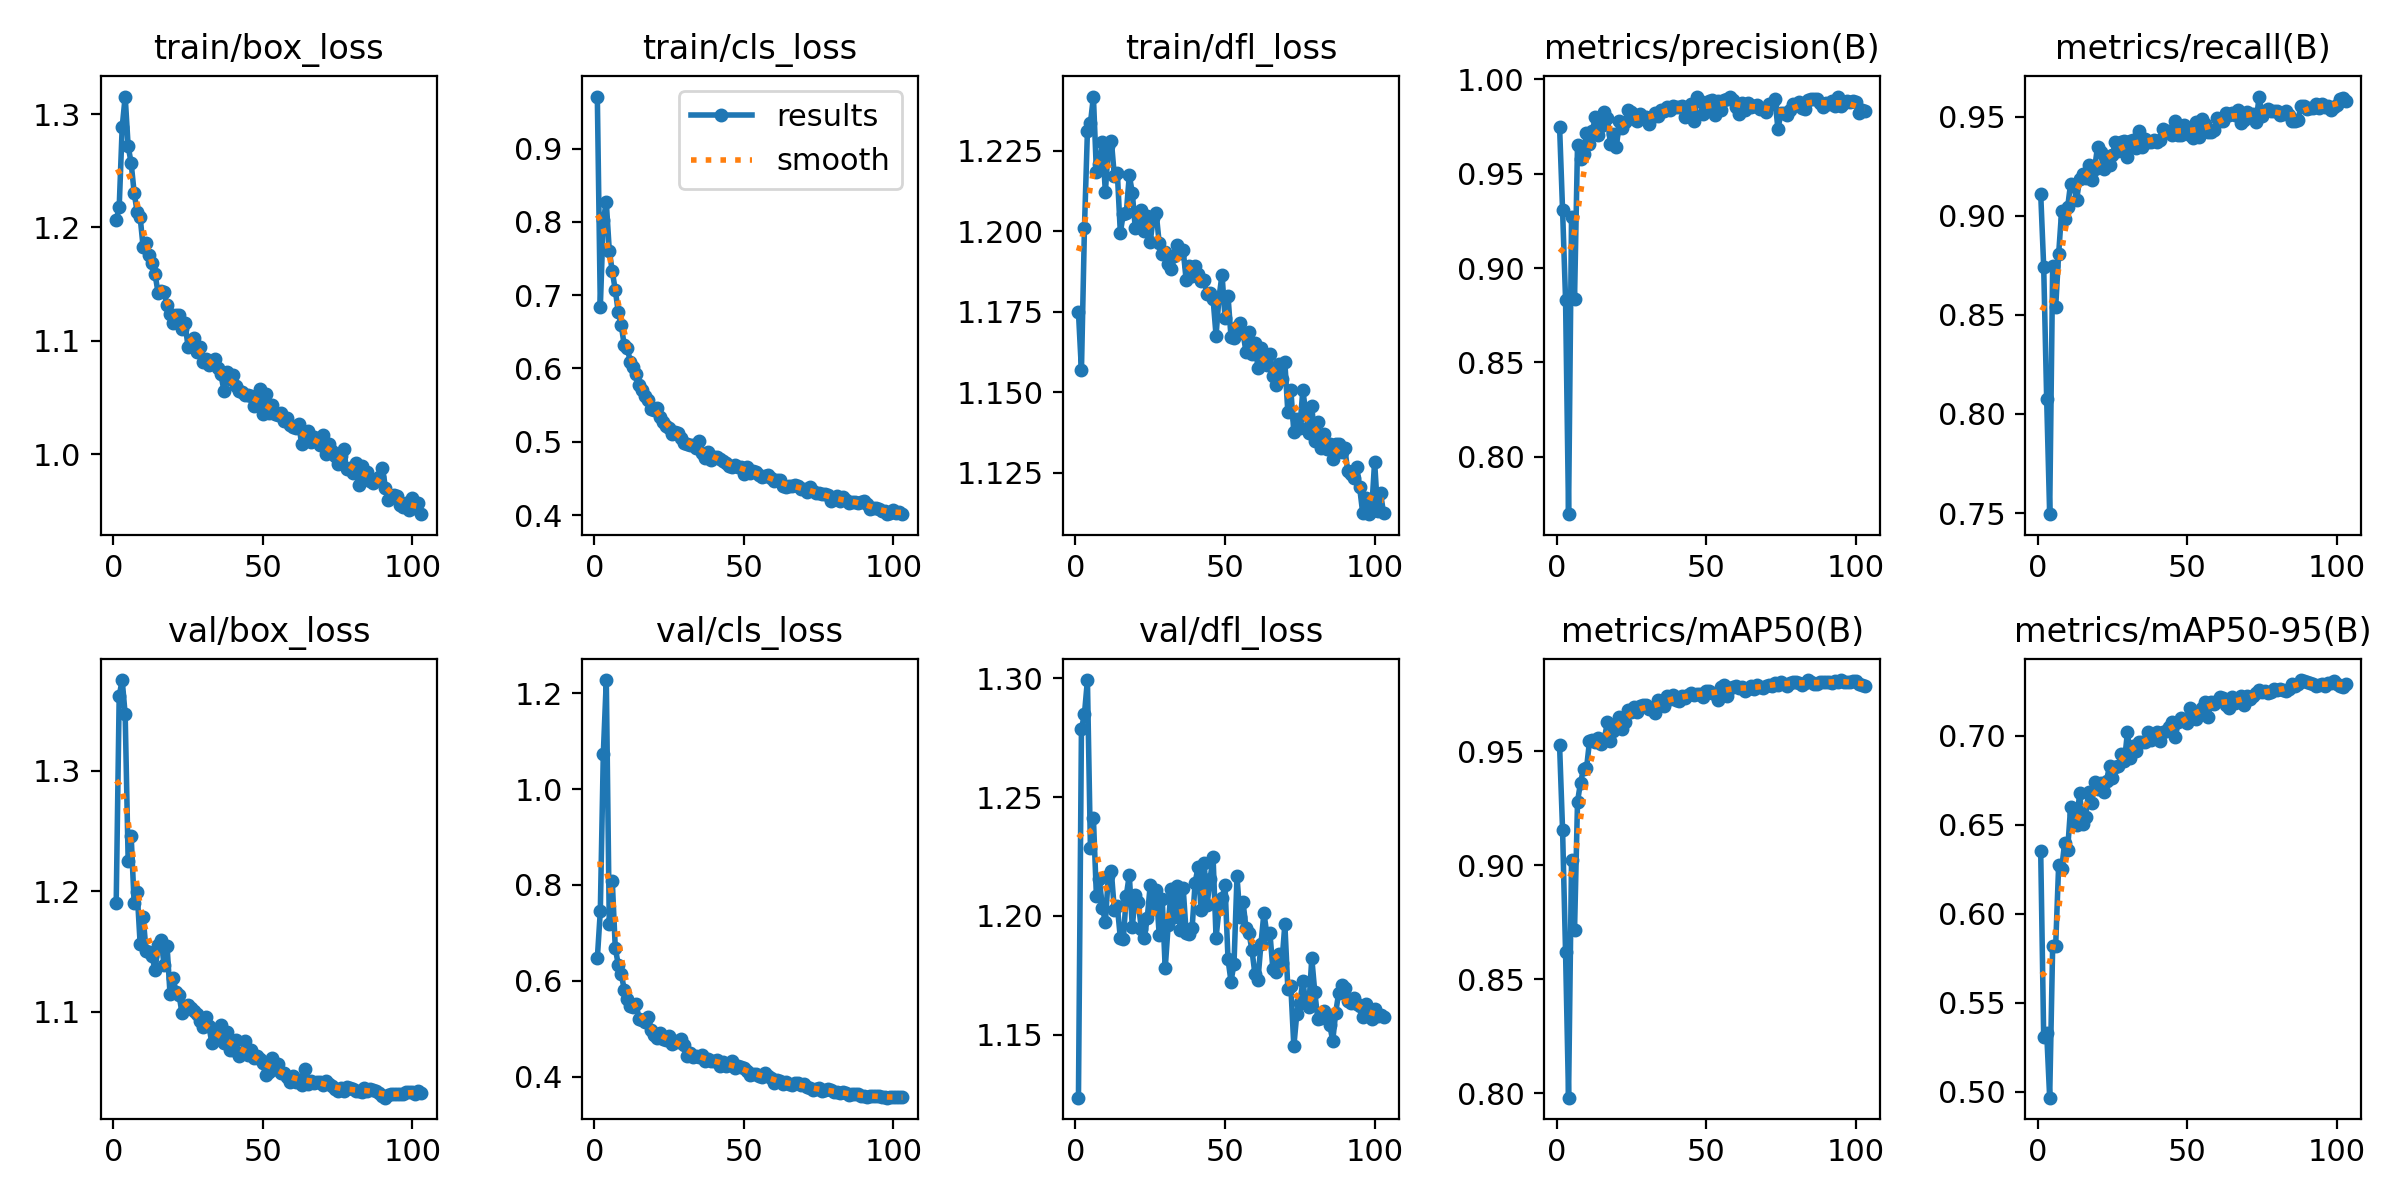

In [ ]:
from IPython.display import Image, display
results_file = f"{project_dir}/runs/detect/license-plate-finetune-v1n/results.png"
display(Image(filename=results_file))

# Convert To ONNX

In [ ]:
!pwd

In [ ]:
!pip install onnxsim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 108.8 MB/s eta 0:00:00


In [ ]:
model_name = ""

In [ ]:
from ultralytics import YOLO
import os
import shutil

project_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision Workshop/License Plate Detection"
model_path = os.path.join(project_dir, f"runs/detect/{model_name}/weights/best.pt")
output_path = os.path.join(project_dir, f"runs/detect/{model_name}/weights/{model_name}.onnx")


In [ ]:
model_path

In [ ]:
output_path

In [ ]:
# load best.pt model
model = YOLO(model_path)

# export
result = model.export(format="onnx", dynamic=True, simplify=True)

# move .onnx file to output path
default_output = result  # default is .onnx path
shutil.move(default_output, output_path)